In [1]:
import scqubits as scq
import numpy as np
from systemclass import SNAIL
import autograd.numpy as np
import scipy as sci
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []
 
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)

def SNAIL(phi_ex,beta,N,Ej,Ec):
    phi_ex = phi_ex*2*np.pi
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    c3 = -(N**2-1)/N**2*beta*np.sin(phi_min-phi_ex)
    
    
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej * phi_zpf ** 3 * c3 / 3 / 2
    print(g3/2/np.pi)
    sdim = 6
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs =( omega_s * np.matmul(sd,s)
        - Ej*(beta*sci.linalg.cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*sci.linalg.cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    phi_op = phi_zpf * (s+sd)
    charge_op = -1j*(s-sd)/(2*phi_zpf)
    energy0,U = np.linalg.eigh(Hs)
    energy0,U = sort_eigenpairs(energy0, U)
    energy0 = energy0 - energy0[0]
    Ud = U.transpose().conjugate()
    Hs = Ud@Hs@U
    Hs = Hs - Hs[0,0]*np.identity(sdim)
    return Hs,Ud@phi_op@U,Ud@charge_op@U

def coupled_system(phi1, phi2, phi3, g_of):
    # phi3 = 0.4
    Hs, phi_op, charge_op = SNAIL(phi3, 0.2, 3, 30*2*np.pi, 0.2*2*np.pi)
    dims = 6
    d1 = d2 = 4
    os_dim = 4

    # Define Fluxonium devices
    fluxonium1 = scq.Fluxonium(
        EJ=4.6,
        EC=0.9,
        EL=1.2,
        cutoff=110,
        flux=phi1,
        truncated_dim=d1
    )
    fluxonium2 = scq.Fluxonium(
        EJ=5.5,
        EC=0.9,
        EL=1.2,
        cutoff=110,
        flux=phi2,
        truncated_dim=d2
    )

    # Hamiltonians for the devices
    H1 = fluxonium1.hamiltonian(energy_esys=True) * 2 * np.pi
    H2 = fluxonium2.hamiltonian(energy_esys=True) * 2 * np.pi
    H1 = H1 - np.identity(d1) * H1[0, 0]
    H2 = H2 - np.identity(d2) * H2[0, 0]

    # Identity matrices for tensor products
    If1 = np.identity(d1)
    If2 = np.identity(d2)
    Is = np.identity(dims)
    Io = np.identity(os_dim)

    # Oscillator Hamiltonian
    ad = creation(os_dim)
    a = annihilation(os_dim)
    Ho = 5 * 2 * np.pi * ad @ a
    phi_os = a + ad

    # Tensor product expansions
    Hs = np.kron(np.kron(np.kron(Hs, Io), If1), If2)
    Ho = np.kron(np.kron(np.kron(Is, Ho), If1), If2)
    H1 = np.kron(np.kron(np.kron(Is, Io), H1), If2)
    H2 = np.kron(np.kron(np.kron(Is, Io), If1), H2)

    # Interaction Hamiltonians
    g_int1 = 0.3 * 2 * np.pi
    g_int2 = -0.3 * 2 * np.pi
    H_int1 = g_int1 * np.kron(np.kron(np.kron(phi_op, Io), fluxonium1.phi_operator(energy_esys=True)), If2)
    H_int2 = g_int2 * np.kron(np.kron(np.kron(phi_op, Io), If1), fluxonium2.phi_operator(energy_esys=True))
    H_int3 = g_of * np.kron(np.kron(np.kron(Is, phi_os), fluxonium1.phi_operator(energy_esys=True)), If2)
    H_int4 = g_of * np.kron(np.kron(np.kron(Is, phi_os), If1), fluxonium2.phi_operator(energy_esys=True))

    # Complete Hamiltonian
    H = Hs + Ho + H1 + H2 + H_int1 + H_int2 + H_int3 + H_int4

    # Charge operators for later transformations
    hc1 = np.kron(np.kron(np.kron(charge_op, Io), If1), If2)
    hc2 = np.kron(np.kron(np.kron(Is, -1j * (a - ad)), If1), If2)

    # Diagonalize the Hamiltonian
    energy0, U = np.linalg.eigh(H)
    energy0, U = sort_eigenpairs(energy0, U)
    energy0 -= energy0[0]
    Ud = U.T.conjugate()
    H = np.diag(energy0)
    hc1 = Ud @ hc1 @ U
    hc2 = Ud @ hc2 @ U
    return energy0, hc1, hc2

def calculate_l1_l2(phi1, phi2, phi3, g_of):
    energy0, _, _ = coupled_system(phi1, phi2, phi3, g_of)
    sorted_energy = np.sort(energy0) / (2 * np.pi)
    l1 = sorted_energy[1]
    l2 = sorted_energy[2]
    return l1, l2

def calculate_zz(phi1, phi2, phi3, g_of):
    energy0, _, _ = coupled_system(phi1, phi2, phi3, g_of)
    sorted_energy = np.sort(energy0) / (2 * np.pi)
    l1 = sorted_energy[1]
    l2 = sorted_energy[2]
    return sorted_energy[3] - l1 - l2

def cost_func(phi1, phi2, phi3, g_of):
    l1, l2 = calculate_l1_l2(phi1, phi2, phi3, g_of)
    h = 1e-5
    zz = calculate_zz(phi1, phi2, phi3, g_of)
    l1_forward_phi1, l2_forward_phi1 = calculate_l1_l2(phi1 + h, phi2,phi3,g_of)
    l1_backward_phi1, l2_backward_phi1 = calculate_l1_l2(phi1 - h, phi2,phi3,g_of)

    dl1_dphi1 = (l1_forward_phi1 - l1_backward_phi1) / (2 * h)
    dl2_dphi1 = (l2_forward_phi1 - l2_backward_phi1) / (2 * h)

    # Derivatives with respect to phi2
    l1_forward_phi2, l2_forward_phi2 = calculate_l1_l2(phi1, phi2 + h,phi3,g_of)
    l1_backward_phi2, l2_backward_phi2 = calculate_l1_l2(phi1, phi2 - h,phi3,g_of)

    dl1_dphi2 = (l1_forward_phi2 - l1_backward_phi2) / (2 * h)
    dl2_dphi2 = (l2_forward_phi2 - l2_backward_phi2) / (2 * h)
    return np.abs(dl1_dphi1) + np.abs(dl2_dphi1) + np.abs(dl1_dphi2) + np.abs(dl2_dphi2)

def gradient(phi1, phi2, phi3, g_of):
    h = 1e-5  # Step size for finite differences
    
    # Get base energy levels
    energy0, _, _ = coupled_system(phi1, phi2, phi3, g_of)
    sorted_energy = np.sort(energy0) / (2 * np.pi)
    l1 = sorted_energy[1]
    l2 = sorted_energy[2]
    l3 = sorted_energy[3]
    
    # Derivative with respect to phi1
    energy_plus, _, _ = coupled_system(phi1 + h, phi2, phi3, g_of)
    energy_minus, _, _ = coupled_system(phi1 - h, phi2, phi3, g_of)
    
    sorted_energy_plus = np.sort(energy_plus) / (2 * np.pi)
    sorted_energy_minus = np.sort(energy_minus) / (2 * np.pi)
    
    dl1_dphi1 = (sorted_energy_plus[1] - sorted_energy_minus[1]) / (2 * h)
    dl2_dphi1 = (sorted_energy_plus[2] - sorted_energy_minus[2]) / (2 * h)
    dl3_dphi1 = (sorted_energy_plus[3] - sorted_energy_minus[3]) / (2 * h)
    
    # Derivative with respect to phi2
    energy_plus, _, _ = coupled_system(phi1, phi2 + h, phi3, g_of)
    energy_minus, _, _ = coupled_system(phi1, phi2 - h, phi3, g_of)
    
    sorted_energy_plus = np.sort(energy_plus) / (2 * np.pi)
    sorted_energy_minus = np.sort(energy_minus) / (2 * np.pi)
    
    dl1_dphi2 = (sorted_energy_plus[1] - sorted_energy_minus[1]) / (2 * h)
    dl2_dphi2 = (sorted_energy_plus[2] - sorted_energy_minus[2]) / (2 * h)
    dl3_dphi2 = (sorted_energy_plus[3] - sorted_energy_minus[3]) / (2 * h)
    
    # Derivative with respect to phi3
    energy_plus, _, _ = coupled_system(phi1, phi2, phi3 + h, g_of)
    energy_minus, _, _ = coupled_system(phi1, phi2, phi3 - h, g_of)
    
    sorted_energy_plus = np.sort(energy_plus) / (2 * np.pi)
    sorted_energy_minus = np.sort(energy_minus) / (2 * np.pi)
    
    dl1_dphi3 = (sorted_energy_plus[1] - sorted_energy_minus[1]) / (2 * h)
    dl2_dphi3 = (sorted_energy_plus[2] - sorted_energy_minus[2]) / (2 * h)
    dl3_dphi3 = (sorted_energy_plus[3] - sorted_energy_minus[3]) / (2 * h)

    # Return gradients
    return {
        'dl1_dphi1': dl1_dphi1, 'dl2_dphi1': dl2_dphi1, 'dl3_dphi1': dl3_dphi1,
        'dl1_dphi2': dl1_dphi2, 'dl2_dphi2': dl2_dphi2, 'dl3_dphi2': dl3_dphi2,
        'dl1_dphi3': dl1_dphi3, 'dl2_dphi3': dl2_dphi3, 'dl3_dphi3': dl3_dphi3
    }


In [2]:
phi3 = 0.43
snail_energy = np.diag(SNAIL(phi3, 0.2, 3, 30*2*np.pi, 0.2*2*np.pi)[0]/2/np.pi)

[0.09009602]


In [3]:
snail_energy

array([ 0.        ,  3.12361955,  6.25291247,  9.4204401 , 13.22666675,
       16.99019107])

In [4]:

def objective_function(x, phi3,gof):
    phi1, phi2 = x
    return cost_func(phi1, phi2, phi3,gof)

# Define a callback function that will stop the optimization when the cost is less than 0.1
def check_termination(xk):
    cost = objective_function(xk, phi3,gof)
    if cost < 0.1:
        return True  # Return True to tell the optimizer to terminate

# Initial guess for phi1 and phi2
initial_guess = [0.5, 0.5]

# Bounds for phi1 and phi2
bounds = [(0.49, 0.51), (0.49, 0.51)]

# Define the value for phi3
phi3 = 0.43
gof = -0*2*np.pi
# Perform the optimization using L-BFGS-B
result = sci.optimize.minimize(objective_function, initial_guess, args=(phi3,gof), method='L-BFGS-B', bounds=bounds, callback=check_termination, options={'disp': True})


[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42609D+01    |proj g|=  1.00000D-02
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]
[0.09009602]

In [5]:
result.x

array([0.49672619, 0.50336716])

In [3]:
phi1,phi2 = result.x
phi1,phi2 = np.array([0.49664695, 0.50333906])

In [4]:
# result.x

In [24]:
gof_values = np.linspace(-0, -0.25, 20) * 2 * np.pi  # 100 points between -0.1 and -0.2 times 2*pi
zz_values = [calculate_zz(phi1, phi2, phi3, gof) for gof in gof_values]


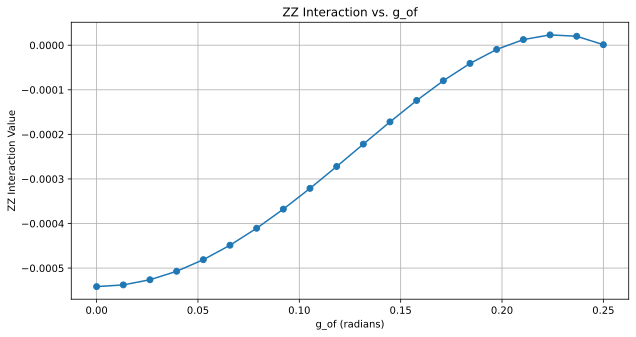

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(-gof_values/2/np.pi, zz_values, marker='o', linestyle='-')
plt.title("ZZ Interaction vs. g_of")
plt.xlabel("g_of (radians)")
plt.ylabel("ZZ Interaction Value")
plt.grid(True)
plt.show()

In [26]:
g_of = -0.202*2*np.pi
calculate_zz(phi1, phi2, phi3, g_of) 

-4.739336509351766e-07

In [13]:
gradient(phi1, phi2, phi3,  g_of) 

{'dl1_dphi1': -0.0458066347963637,
 'dl2_dphi1': 0.00774274968029509,
 'dl3_dphi1': 0.07005211430377578,
 'dl1_dphi2': -0.0015725075991346313,
 'dl2_dphi2': 0.14935732765841703,
 'dl3_dphi2': -0.15319855360407253,
 'dl1_dphi3': -0.04296883809318252,
 'dl2_dphi3': -0.1524268652769445,
 'dl3_dphi3': -0.19425575288334326}

In [11]:
energy,hc1,hc2 = coupled_system(phi1, phi2, phi3, g_of)
print(hc1[0,1],hc1[0,5],hc1[0,6])
print(hc1[1,5],hc1[1,6],)
print(hc1[5,6],)

0.01912623474878802j -0.0028032537971756657j 0.0020659696578867724j
-0.03003257325274275j -0.011890493859412722j
-0.20027193229373294j


In [11]:
hc1[0:4,0:4]

array([[0.+4.85180472e-18j, 0.+1.78727328e-02j, 0.+1.72575256e-02j,
        0.-6.47625220e-04j],
       [0.-1.78727328e-02j, 0.+8.29414662e-18j, 0.-1.83245308e-01j,
        0.+5.01462464e-02j],
       [0.-1.72575256e-02j, 0.+1.83245308e-01j, 0.+6.99310401e-18j,
        0.-1.65211955e-01j],
       [0.+6.47625220e-04j, 0.-5.01462464e-02j, 0.+1.65211955e-01j,
        0.+3.12250226e-17j]])

In [12]:
print(hc2[0,1],hc2[0,5],hc2[0,6])
print(hc2[1,5],hc2[1,6],)
print(hc2[5,6],)

0.010382603849216328j -6.447930931188371e-05j 0.009419133439428056j
0.015914245631324507j -0.0005362081093531801j
0.17381926750134766j


In [13]:
hc2[0:4,0:4]

array([[0.-9.71518950e-19j, 0.+1.03826038e-02j, 0.-4.38712151e-04j,
        0.+7.72510876e-02j],
       [0.-1.03826038e-02j, 0.-3.53434817e-18j, 0.+2.00905105e-01j,
        0.-3.18341137e-03j],
       [0.+4.38712151e-04j, 0.-2.00905105e-01j, 0.-4.53904294e-19j,
        0.-5.75368869e-02j],
       [0.-7.72510876e-02j, 0.+3.18341137e-03j, 0.+5.75368869e-02j,
        0.-1.12033019e-18j]])

In [137]:
from joblib import Parallel, delayed
phi3_values = np.linspace(0.001, 0.44, 20)
def process_phi3(phi3, initial_guess, bounds):
    # Perform the optimization for the current phi3
    result = sci.optimize.minimize(objective_function, initial_guess, args=(phi3,g_of), method='L-BFGS-B', bounds=bounds)
    
    # Calculate the energies and sort them
    energy, _,_ = coupled_system(result.x[0], result.x[1],phi3,g_of)
    energy = energy / (2 * np.pi)
    sort_energy = np.sort(energy)
    
    # Calculate zz
    zz = calculate_zz(result.x[0], result.x[1], phi3,g_of)
    
    return sort_energy, zz
# Arrays to store the results
sort_energy_results = np.zeros((50, 4))
zz_results = np.zeros(50)

# Initial guess and bounds for optimization
initial_guess = [0.5, 0.5]
bounds = [(0.45, 0.55), (0.45, 0.55)]

# Parallelize the computation using joblib
results = Parallel(n_jobs=-1)(delayed(process_phi3)(phi3, initial_guess, bounds) for phi3 in phi3_values)

# Extract the results
sort_energy_results = np.array([result[0] for result in results])
zz_results = np.array([result[1] for result in results])


KeyboardInterrupt: 

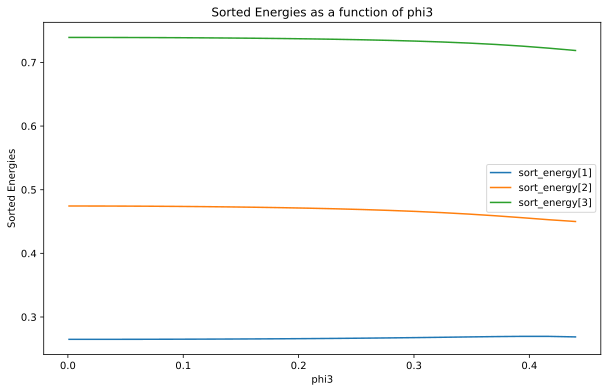

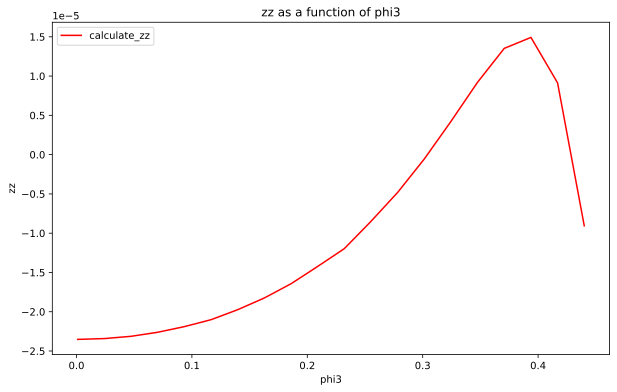

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# plt.plot(phi3_values, sort_energy_results[:, 0], label='sort_energy[0]')
plt.plot(phi3_values, sort_energy_results[:, 1], label='sort_energy[1]')
plt.plot(phi3_values, sort_energy_results[:, 2], label='sort_energy[2]')
plt.plot(phi3_values, sort_energy_results[:, 3], label='sort_energy[3]')
plt.xlabel('phi3')
plt.ylabel('Sorted Energies')
plt.legend()
plt.title('Sorted Energies as a function of phi3')
plt.show()

# Example of plotting zz_results as a function of phi3
plt.figure(figsize=(10, 6))
plt.plot(phi3_values, zz_results, label='calculate_zz', color='red')
plt.xlabel('phi3')
plt.ylabel('zz')
plt.title('zz as a function of phi3')
plt.legend()
plt.show()

In [27]:
def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

In [28]:
energy0, hc1, hc2 = coupled_system(phi1, phi2, phi3, g_of)

In [29]:
indices = []
for energy in snail_energy:
    # Calculate absolute differences and find the index of the minimum difference
    index = np.argmin(np.abs(energy0/2/np.pi - energy))
    indices.append(index)

In [17]:
hc1[0:4,0:4]

array([[0.+6.64073831e-18j, 0.+1.78727330e-02j, 0.+1.72575382e-02j,
        0.-6.47640554e-04j],
       [0.-1.78727330e-02j, 0.+5.12285526e-18j, 0.-1.83245302e-01j,
        0.+5.01462646e-02j],
       [0.-1.72575382e-02j, 0.+1.83245302e-01j, 0.+1.40946282e-18j,
        0.-1.65211938e-01j],
       [0.+6.47640554e-04j, 0.-5.01462646e-02j, 0.+1.65211938e-01j,
        0.+3.46944695e-18j]])

In [30]:
ff1 = 0.3*2*np.pi
ff2 = 0.5*2*np.pi
index1 = np.argmin(np.abs(energy0 - ff1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - ff2 * np.ones(len(energy0))))
index3 = np.argmin(np.abs(energy0 - (ff2+ff1) * np.ones(len(energy0))))
# index3 = 3


In [19]:
index1,index2,index3

(1, 4, 5)

In [31]:
import qutip as qt
total_dim = 4*4*6*4
H = np.diag(energy0)
H0=qt.Qobj(H)
hc =qt.Qobj(hc1)

In [32]:
(H0/2/np.pi)[index3][index3]-(H0/2/np.pi)[0][0]

(0.7016322202897346+0j)

In [33]:
(H0/2/np.pi)[index3][index3]-(H0/2/np.pi)[0][0]

(0.7016322202897346+0j)

In [34]:
(H0/2/np.pi)

Quantum object: dims=[[384], [384]], shape=(384, 384), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.26200056  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          4.35157049 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 43.28311018  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         27.86158702
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  27.07917337]]

In [35]:
hc

Quantum object: dims=[[384], [384]], shape=(384, 384), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+6.64073831e-18j 0.+1.78727330e-02j 0.+1.72575382e-02j ...
  0.-2.25460624e-09j 0.+1.33129971e-06j 0.+9.03442509e-07j]
 [0.-1.78727330e-02j 0.+5.12285526e-18j 0.-1.83245302e-01j ...
  0.-4.08194423e-09j 0.+1.42588696e-06j 0.+6.44784690e-07j]
 [0.-1.72575382e-02j 0.+1.83245302e-01j 0.+1.40946282e-18j ...
  0.-5.54041312e-09j 0.-1.71976398e-06j 0.+7.63313749e-06j]
 ...
 [0.+2.25460624e-09j 0.+4.08194423e-09j 0.+5.54041312e-09j ...
  0.+9.56537367e-17j 0.+7.50487868e-03j 0.-3.57384993e-04j]
 [0.-1.33129971e-06j 0.-1.42588696e-06j 0.+1.71976398e-06j ...
  0.-7.50487868e-03j 0.+9.10729825e-18j 0.+4.72350574e-03j]
 [0.-9.03442509e-07j 0.-6.44784690e-07j 0.-7.63313749e-06j ...
  0.+3.57384993e-04j 0.-4.72350574e-03j 0.+7.63278329e-17j]]

In [20]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Assuming all necessary functions and variables are defined earlier

def calculate_exp_P3(omega, H0, hc, psi0, PP3, tlist, drive_func):
    args = {'w': omega}
    H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])
    return exp_P3

psi0 = qt.basis(total_dim, 0)
PP0 = qt.basis(total_dim, 0)*qt.basis(total_dim, 0).dag()
PP1 = qt.basis(total_dim, index1)*qt.basis(total_dim, index1).dag()
PP2 = qt.basis(total_dim, index2)*qt.basis(total_dim, index2).dag()
PP3 = qt.basis(total_dim, index3)*qt.basis(total_dim, index3).dag()
duration = 150
# 0.7063157894736841
drive_func = gaussian_ramp(20, duration, 2.*2*np.pi)
omega_range = np.linspace(0.68, 0.69, 20) * 2 * np.pi  # 20 points between 1.276 and 1.28
tlist = np.linspace(0, duration+5, 12000)  # Cover ten periods

# Parallel computation
exp_P3_list = Parallel(n_jobs=-1)(delayed(calculate_exp_P3)(
    omega, H0, hc, psi0, PP3, tlist, drive_func) for omega in omega_range)

# Plotting
plt.figure(figsize=(12, 8))
for i, omega in enumerate(omega_range):
    plt.plot(tlist, exp_P3_list[i], label=f'ω = {omega/(2*np.pi):.4f}')

plt.xlabel('Time')
plt.ylabel('Expectation value of P3')
plt.title('Expectation value of P3 for different ω values')
plt.legend()
plt.grid(True)
plt.show()
print(omega_range[max_index]/2/np.pi)

KeyboardInterrupt: 

In [37]:
import numpy as np
import qutip as qt
from joblib import Parallel, delayed
PP3 = qt.basis(total_dim, index3)*qt.basis(total_dim, index3).dag()
def simulate_fidelity(duration, omega):
    drive_func = gaussian_ramp(10,duration, 2*2*np.pi)
    args = {'w': omega}
    tlist = np.linspace(0, duration+10, 10000)  # Cover ten periods
    # Hamiltonian with time-dependent part
    H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]

    # Solve the dynamics
    result = qt.sesolve(H, psi0, tlist, args={'w': omega})

    # Calculate expectation values
    exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])
    
    # Return the final fidelity (last value of exp_P3)
    return exp_P3[-1]
durations = np.linspace(104,106,5)
frequencies = np.linspace(0.68056, 0.68069 , 5) * 2 * np.pi  # 3 steps from 0.698 to 0.700

# Parallel execution using joblib
results = Parallel(n_jobs=-1)(delayed(simulate_fidelity)( dur, freq)
                              for dur in durations
                              for freq in frequencies)


KeyboardInterrupt: 

In [26]:
results_matrix = []
counter = 0
for i in range(len(durations)):
    row = []
    for j in range(len(frequencies)):
        row.append(results[counter])
        counter += 1
    results_matrix.append(row)
    # Printing frequencies for header
header = [" {:.5f} ".format(freq / (2 * np.pi)) for freq in frequencies]
print("          ", "  ".join(header))

# Print each row
for i, row in enumerate(results_matrix):
    print(f"Duration {durations[i]}: ", " ".join(f"{x:.6f}" for x in row))

In [28]:
# Printing frequencies for header
header = [" {:.5f} ".format(freq / (2 * np.pi)) for freq in frequencies]
print("          ", "  ".join(header))

# Print each row
for i, row in enumerate(results_matrix):
    print(f"Duration {durations[i]}: ", " ".join(f"{x:.6f}" for x in row))

            0.68056    0.68059    0.68063    0.68066    0.68069 
Duration 104.0:  0.999748 0.999849 0.999853 0.999767 0.999565
Duration 104.5:  0.999858 0.999936 0.999941 0.999854 0.999698
Duration 105.0:  0.999845 0.999917 0.999908 0.999825 0.999647
Duration 105.5:  0.999686 0.999771 0.999764 0.999674 0.999515
Duration 106.0:  0.999431 0.999516 0.999508 0.999420 0.999227


In [38]:
i0 = qt.basis(total_dim, 0)
i1 = qt.basis(total_dim, index1)
i2 = qt.basis(total_dim, index2)
i3 = qt.basis(total_dim, index3)
initial_states = [i0,i1,i2,i3]
duration =104.5
drive_func = gaussian_ramp(10,duration, 2*2*np.pi)
omega = 0.680631*2*np.pi
args = {'w': omega}
tlist = np.linspace(0, duration+10, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(omega*t)]]
def evolve_state(psi0):
    result = qt.sesolve(H, psi0, tlist, args=args)
    return result.states[-1]
# Define options directly as a dictionary with increased nsteps
final_states = Parallel(n_jobs=-1)(delayed(evolve_state)(state) for state in initial_states)


In [39]:
final_states = np.array(final_states)
t0 = qt.basis(total_dim, index3)
t1 = qt.basis(total_dim, index1)
t2 = qt.basis(total_dim, index2)
t3 = qt.basis(total_dim, 0)
target_unitary = np.array([t0,t1,t2,t3])

In [44]:
sum0 = 0
sum1 = 0
for i in range(4):
    sum0+=np.abs(final_states[i].dag()*target_unitary[i])**2
    print(final_states[i].dag()*target_unitary[i])
    sum1 +=final_states[i].dag()*target_unitary[i]

(-0.1345652314978353-0.9908715047103518j)
(0.911590410507443-0.4110759192437629j)
(-0.9715113304849309-0.23690288619865457j)
(-0.2866440392028472+0.9580153923313799j)


In [57]:
global_phase = thetas[0]

# Adjust all phase angles relative to the global phase
adjusted_thetas = [theta - global_phase for theta in thetas]

# Convert adjusted complex numbers to exponential form e^(i*adjusted_theta)
adjusted_exponential_forms = [f"e^(i*{theta:.5f})" for theta in adjusted_thetas]

adjusted_exponential_forms

['e^(i*0.00000)', 'e^(i*1.28214)', 'e^(i*-1.19664)', 'e^(i*3.56730)']

In [62]:
-5.086545307179586-1.28214+3.56730

-2.801385307179586

In [59]:
psi0 = qt.basis(total_dim, 0)
PP0 = qt.basis(total_dim, 0)*qt.basis(total_dim, 0).dag()
PP1 = qt.basis(total_dim, index1)*qt.basis(total_dim, index1).dag()
PP2 = qt.basis(total_dim, index2)*qt.basis(total_dim, index2).dag()
PP3 = qt.basis(total_dim, index3)*qt.basis(total_dim, index3).dag()
duration =105
drive_func = gaussian_ramp(5,duration, 2*2*np.pi)
omega = 0.6997368421052631*2*np.pi
args = {'w': omega}
tlist = np.linspace(0, duration+5, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
result = qt.sesolve(H, psi0, tlist, args=args)
exp_P0 = np.array([qt.expect(PP0, state) for state in result.states])
exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])

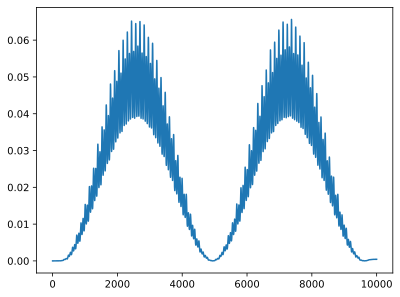

In [61]:
plt.plot(exp_P3)

In [199]:
num_states = total_dim # or however many states your system has
states_of_interest = np.arange(0, 81, 16)  # states 0, 16, 32, 48, 64, 80

projection_operators = [qt.basis(num_states, state) * qt.basis(num_states, state).dag() for state in states_of_interest]
populations = {state: [] for state in states_of_interest}

# Loop over each time point and calculate the population for each state
for state_vector in result.states:
    for state in states_of_interest:
        # Project the state_vector onto the state basis and get the probability (population)
        pop = (projection_operators[state // 16] * state_vector).norm()**2
        populations[state].append(pop)

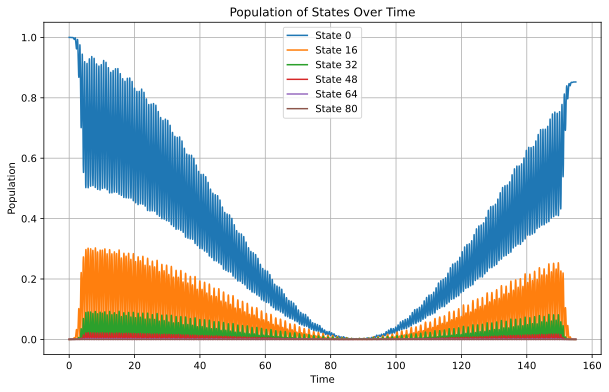

In [200]:
# Plotting the results
plt.figure(figsize=(10, 6))
for state in states_of_interest:
    plt.plot(tlist, populations[state], label=f'State {state}')

plt.title('Population of States Over Time')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


In [249]:
print(index1,index2,index3)

1 4 5


0.6805263157894738

In [76]:
amplitude = []
for t in tlist:
    amplitude.append(drive_func(t)/2/np.pi)
from matplotlib import pyplot as plt
plt.plot(tlist,amplitude)

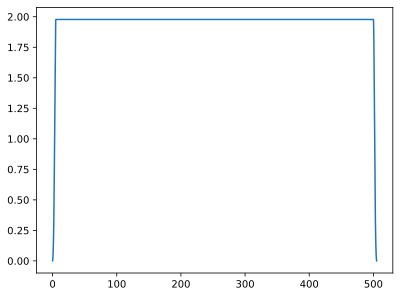

In [84]:
from matplotlib import pyplot as plt
plt.plot(tlist,amplitude)

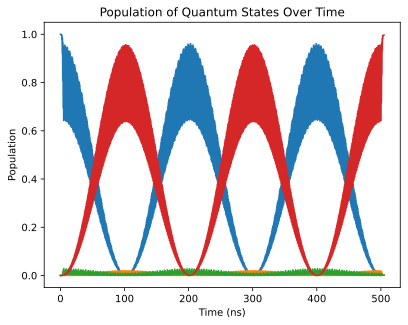

In [85]:
from matplotlib import pyplot as plt
exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])
# Plotting each expectation value series
plt.plot(tlist,exp_P0, label='|0000>')  # Population of state |0000>
plt.plot(tlist,exp_P1, label='|0001>')  # Population of state |0001>
plt.plot(tlist,exp_P2, label='|1000>')  # Population of state |1000>
plt.plot(tlist,exp_P3, label='|1001>')  # Population of state |1001>

# Adding a legend to the plot
# plt.legend()

# Adding titles and labels (optional but recommended for clarity)
plt.title('Population of Quantum States Over Time')
plt.xlabel('Time (ns)')
plt.ylabel('Population')

# Display the plot
plt.show()

In [83]:
exp_P3[-1]

0.9965621784056615